In [1]:
import sys
sys.path.insert(0, "/workspace")   # add workspace as import root
import tensorflow as tf

tf.config.optimizer.set_jit(False)           # disables XLA JIT
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tensorflow_htv.helpers import display_tensorboard_logs

In [2]:
display_tensorboard_logs()

In [3]:
tf.__version__

'2.17.0'

In [4]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
!nvidia-smi

Sat Dec 20 17:00:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 590.44.01              Driver Version: 591.44         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   44C    P8              7W /   79W |     223MiB /  12227MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# import zipfile
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# # Unzip the downloaded file

# zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
# zip_ref.extractall()
# zip_ref.close()

In [7]:
train_dir = "data/10_food_classes_10_percent/train"
test_dir = "data/10_food_classes_10_percent/test"

class_names = sorted(os.listdir(train_dir))
test_cn = sorted(os.listdir(test_dir))

class_names == test_cn

for directory, folders, files in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(folders)} folders and {len(files)} files in '{directory}'")

data/10_food_classes_10_percent/train/ramen/2427642.jpg


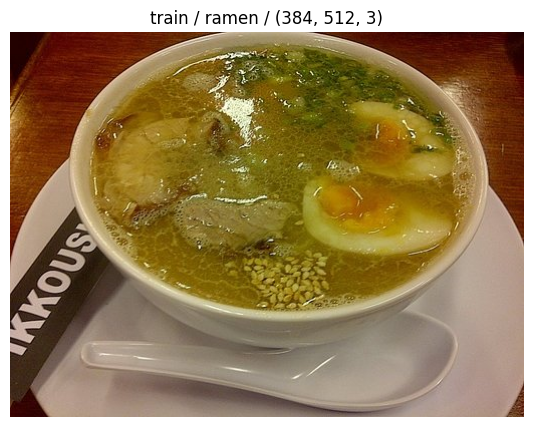

In [8]:
import random
def view_random_image(datapath):
  datasets = sorted(os.listdir(datapath))
  random_dataset = random.choice(datasets)
  class_path = os.path.join(datapath, random_dataset)
  rand_class_name = random.choice(os.listdir(class_path))
  class_path = os.path.join(class_path, rand_class_name)
  randomimg = os.path.join(class_path, random.choice(os.listdir(class_path)))
  print(randomimg)

  img = plt.imread(randomimg)
  plt.figure(figsize=(8, 5))
  plt.imshow(img)
  plt.title(f"{random_dataset} / {rand_class_name} / {img.shape}")
  plt.axis("off")
  plt.show()


view_random_image("data/10_food_classes_10_percent")

In [9]:
## Create train & test ds

IMG_SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=42,
    label_mode="int"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=42,
    label_mode="int"
)

train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


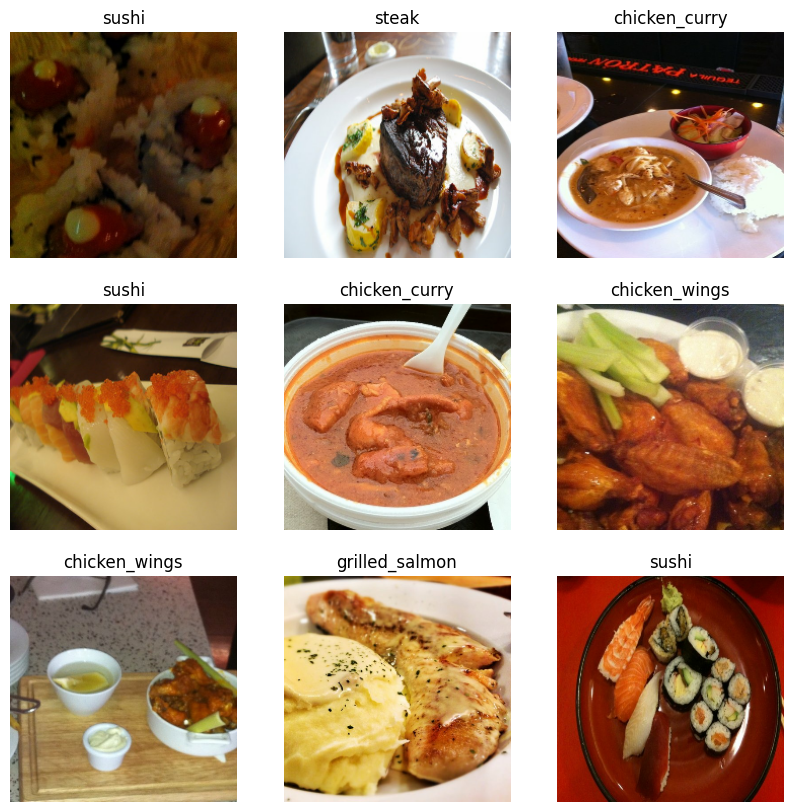

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
## Setting up callbacks
"""
1. Tracking experiments with TensorBoard
2. Model checkpoint with ModelCheckpoint
3. EarlyStopping against overfit
4. ReduceLROnPlateu
5. LearningRateScheduler
"""

import datetime

def create_tensorboard_callback(dir_name, experiment_name):

  log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  print(f"Saving TensorBoard log files to {log_dir}")

  tensorboard_callback = keras.callbacks.TensorBoard(
      log_dir=log_dir,
  )
  return tensorboard_callback

## Tensorflow HUB website
1. https://www.tensorflow.org/hub
2. https://www.kaggle.com/models?tfhub-redirect=true

In [12]:
import keras
keras.__version__

'3.3.2'

In [13]:
import keras
from keras import layers

IMG_SIZE = (224, 224)
num_classes = len(class_names)


def create_efficientnetv2_model(
        variant: str,            # "B0", "B1", "B2", "B3", "L", etc.
        num_classes: int,
        base_trainable=False,
        dropout=0.2,
        lr=1e-3,
    ):

    """
    Create a Keras EfficientNetV2 image classification model for transfer learning.

    This function builds an EfficientNetV2 backbone pretrained on ImageNet,
    removes the original classification head, and attaches a new Dense
    softmax classifier for a custom number of classes.

    The input image size is automatically selected based on the EfficientNetV2
    variant (B0–L), ensuring compatibility with the pretrained architecture.

    Parameters
    ----------
    variant : str
        EfficientNetV2 variant identifier.
        Supported values: "B0", "B1", "B2", "B3", "S", "M", "L".
    num_classes : int
        Number of output classes for classification.
    base_trainable : bool, optional
        Whether the EfficientNetV2 backbone is trainable.
        Set to False for feature extraction (default),
        True for fine-tuning.
    dropout : float, optional
        Dropout rate applied before the classification head.
        Helps reduce overfitting. Default is 0.2.
    lr : float, optional
        Learning rate for the Adam optimizer. Default is 1e-3.

    Returns
    -------
    model : keras.Model
        Compiled Keras model ready for training.
    img_size : tuple[int, int]
        Image size (height, width) required by the selected EfficientNetV2 variant.

    Notes
    -----
    - Labels should be integer-encoded (0 … num_classes-1).
    - The model uses `SparseCategoricalCrossentropy` loss.
    - Input images must be resized to `img_size` when building datasets.
    - For best results:
        1) Train with `base_trainable=False` (feature extraction).
        2) Unfreeze part of the backbone and recompile with a smaller
           learning rate (e.g., 1e-5) for fine-tuning.

    Examples
    --------
    >>> model, img_size = create_efficientnetv2_model("B0", num_classes=10)
    >>> train_ds = tf.keras.utils.image_dataset_from_directory(
    ...     train_dir, image_size=img_size, label_mode="int"
    ... )
    >>> model.fit(train_ds, epochs=5)
    """
    model_name = f"EfficientNetV2{variant}"

    try:
        BaseModel = getattr(keras.applications, model_name)
    except AttributeError:
        raise ValueError(f"Invalid EfficientNetV2 variant: {variant}")

    EFFICIENTNETV2_SIZES = {
        "B0": (224, 224),
        "B1": (240, 240),
        "B2": (260, 260),
        "B3": (300, 300),
        "S":  (384, 384),
        "M":  (480, 480),
        "L":  (480, 480),
    }

    img_size = EFFICIENTNETV2_SIZES[variant]

    base = BaseModel(
        include_top=False,
        weights="imagenet",
        input_shape=img_size + (3,),
        pooling="avg",
    )
    base.trainable = base_trainable  # Freeze already learned patterns

    inputs = keras.Input(shape=img_size + (3,))
    x = keras.applications.efficientnet_v2.preprocess_input(inputs)
    x = base(x, training=False) # Freeze already learned patterns
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name=model_name)

    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model





model_efficient_B0 = create_efficientnetv2_model(
    variant="B0",
    num_classes=num_classes
    )
model_efficient_B0.summary()

Model: "EfficientNetV2B0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [14]:
model_efficient_B0.fit(train_ds,
                        validation_data=test_ds,
                        epochs=6,
                        verbose=1,
                        callbacks=create_tensorboard_callback(
                            dir_name="/workspace/tensorflow/tensorboard/",
                            experiment_name="EfficientNetV2B0"
                            )
                        )

Saving TensorBoard log files to /workspace/tensorflow/tensorboard/EfficientNetV2B0/20251220-170050
Epoch 1/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 876ms/step - accuracy: 0.2506 - loss: 2.1739 - val_accuracy: 0.7188 - val_loss: 1.3798
Epoch 2/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.7066 - loss: 1.2948 - val_accuracy: 0.8100 - val_loss: 0.9518
Epoch 3/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8010 - loss: 0.9257 - val_accuracy: 0.8412 - val_loss: 0.7587
Epoch 4/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8499 - loss: 0.7209 - val_accuracy: 0.8480 - val_loss: 0.6580
Epoch 5/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8508 - loss: 0.6363 - val_accuracy: 0.8548 - val_loss: 0.5925
Epoch 6/6
24/24 ━━━━━━━━━━━━━━━━━━━━ -0s -8014us/step - accuracy: 0.8880 - loss: 0.5508 - val_accuracy: 0.8596 - val_loss: 0.5485


In [15]:
import keras
from keras import layers

IMG_SIZE = (224, 224)
num_classes = len(class_names)
lr = 1e-3

# Backbone (constructor, not instance)
base = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,),
    pooling="avg",
)
base.trainable = False  # feature extraction

# Model
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
x = base(x, training=False)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_resnet50 = keras.Model(inputs, outputs, name="ResNet50")

model_resnet50.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model_resnet50.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │     20,490 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
model_resnet50.fit(train_ds,
                        validation_data=test_ds,
                        epochs=6,
                        verbose=1,
                        callbacks=[create_tensorboard_callback(
                            dir_name="/workspace/tensorflow/tensorboard/",
                            experiment_name="Resnet50"
                            )]
                        )

Saving TensorBoard log files to /workspace/tensorflow/tensorboard/Resnet50/20251220-170142
Epoch 1/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 386ms/step - accuracy: 0.2534 - loss: 2.2275 - val_accuracy: 0.6120 - val_loss: 1.1611
Epoch 2/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.6889 - loss: 0.9666 - val_accuracy: 0.7080 - val_loss: 0.8774
Epoch 3/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.7501 - loss: 0.7846 - val_accuracy: 0.7368 - val_loss: 0.7804
Epoch 4/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.8163 - loss: 0.6166 - val_accuracy: 0.7584 - val_loss: 0.7325
Epoch 5/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.8403 - loss: 0.5097 - val_accuracy: 0.7660 - val_loss: 0.6979
Epoch 6/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.8771 - loss: 0.3808 - val_accuracy: 0.7820 - val_loss: 0.6592


In [17]:
import keras
from keras import layers

keras.backend.clear_session()

IMG_SIZE = (224, 224)
num_classes = len(class_names)
lr = 1e-3

base = keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,),
    pooling="avg",
)
base.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
# Correct preprocess for V2 family:
x = keras.applications.resnet_v2.preprocess_input(inputs)

# IMPORTANT: don't force training=False here for V2 in Keras 3; let Keras control it.
x = base(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_resnet50v2 = keras.Model(inputs, outputs, name="ResNet50V2")

model_resnet50v2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model_resnet50v2.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,585,290 (89.97 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [18]:
history_resnet50v2 = model_resnet50v2.fit(
                        train_ds,
                        validation_data=test_ds,
                        epochs=6,
                        callbacks=[create_tensorboard_callback(dir_name="/workspace/tensorflow/tensorboard/", experiment_name="Resnet50V2")],
                        verbose=1
                    )

Saving TensorBoard log files to /workspace/tensorflow/tensorboard/Resnet50V2/20251220-170223
Epoch 1/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.2463 - loss: 2.2729 - val_accuracy: 0.6024 - val_loss: 1.2394
Epoch 2/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.6300 - loss: 1.1331 - val_accuracy: 0.6904 - val_loss: 0.9467
Epoch 3/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.7509 - loss: 0.7694 - val_accuracy: 0.7472 - val_loss: 0.7869
Epoch 4/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8492 - loss: 0.5685 - val_accuracy: 0.7580 - val_loss: 0.7364
Epoch 5/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.8625 - loss: 0.4747 - val_accuracy: 0.7744 - val_loss: 0.6946
Epoch 6/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8734 - loss: 0.4080 - val_accuracy: 0.7760 - val_loss: 0.6796


In [19]:
## Upload tensorboard logs to tensorboard.dev 
# Do not upload private logs 

## Types of Transfer Learning 

1. Using **As is** with no changes (using iamgenet model with only its 1000 clasess, not our your own)
2. **Feature Extraction** model with our own classes
3. **Fine Tuning** Use pre learned patterns of an existing model and fine tune many or all of the underlying layers. 

In [1]:
from IPython.display import HTML
HTML('<a href="http://localhost:6006" target="_blank">Open TensorBoard</a>')


In [25]:
os.listdir("/workspace/tensorflow/tensorboard/")

['EfficientNetV2B0', 'Resnet50', 'Resnet50V2']

In [15]:
display_tensorboard_logs()